In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/pierre/git/ProbNES/semisupervised


In [3]:
import os
import torch
import yaml
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from module.utils import compute_N_colours, create_path_exp
from module.plot_script import ci
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True
supported_labels = [
    "random",
    "local_search",
    "ei",
    "ei_ego_network_1",
    "ei_ego_network_1_old",
    "dfs",
    "bfs",
    "ei_ego_network_2",
    "ei_ego_network_2_no_ard",
]
# cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))
d_color = {"ei_ego_network_1":"#1f77b4", "ei_ego_network_2":"#8c564b", "random":"#ff7f0e",
           "local_search":"#2ca02c", "dfs": "#d62728", "bfs": "#9467bd", "ei_ego_network_1_old":"#e377c2",
           "ei_ego_network_2_no_ard":"#7f7f7f", "ei_ego_network_matern":'#bcbd22'}
d_label = {"ei_ego_network_1":"BO_Poly", "ei_ego_network_1_old":"BO_SumInverse",
           "ei_ego_network_2":"BO_Diff_ARD", "ei_ego_network_2_no_ard":"BO_Diff", 
           "random":"Random", "local_search":"Local search", "dfs": "Dfs", "bfs": "Bfs",
           "ei_ego_network_matern":"BO_Matern"}

algo_to_label = {"probESCMAES": "Prob CMAES (ours)",
                 "probESXNES": "Prob XNES (ours)",
                 "probESSNES": "Prob SNES (ours)",
                 "ESCMAES": "CMAES",
                 "ESXNES": "XNES",
                 "ESSNES": "SNES",
                 "piqEI": r"$\pi$" + "BO",
                 "random": "random",
                 "qEI": "BO",
                 "s_cmaes": "Surrogate CMAES"}

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def alg_name(algorithm_name, alg_kwargs):
  if algorithm_name == "probES":  #["probES", "ES", "random", "qEI", "piqEI"]
    s = "_".join([f'type-{alg_kwargs[algorithm_name]["type"]}', f'policy-{alg_kwargs[algorithm_name]["policy"]}', f'gradient-{alg_kwargs[algorithm_name]["gradient"]}', f'aqc_type-{alg_kwargs[algorithm_name]["aqc_type"]}', f'mahalanobis-{alg_kwargs[algorithm_name]["mahalanobis"]}', f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'lr-{alg_kwargs[algorithm_name]["lr"]}', f'batch_size-{alg_kwargs["batch_size"]}', f'evaluation-{alg_kwargs["evaluation"]}'])
  elif algorithm_name == "ES":
    s = "_".join([f'type-{alg_kwargs[algorithm_name]["type"]}', f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'batch_size-{alg_kwargs["batch_size"]}', f'evaluation-{alg_kwargs["evaluation"]}'])
  elif algorithm_name == "qEI":
    s = "_".join([f'batch_size-{alg_kwargs["batch_size"]}'])
  elif algorithm_name == "piqEI":
    s = "_".join([f'beta-{alg_kwargs[algorithm_name]["beta"]}', f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'batch_size-{alg_kwargs["batch_size"]}']) 
  elif algorithm_name == "random":
    s = "_".join([f'mean_prior-{alg_kwargs[algorithm_name]["mean_prior"]}', f'std_prior-{alg_kwargs[algorithm_name]["std_prior"]}', f'batch_size-{alg_kwargs["batch_size"]}'])
  elif algorithm_name == "s_cmaes":
    s = "_".join(['s_cmaes', 'batch_size-5'])
  return s

def create_path_alg(save_path, algorithm_name, alg_kwargs):
    s = alg_name(algorithm_name, alg_kwargs)
    save_path = os.path.join(save_path, s)
    return save_path

def create_path_exp(save_dir, problem_name, problem_kwargs):
    if problem_name == "test_function":
       s = "_".join([problem_kwargs["function"], f'dim-{problem_kwargs["dim"]}', f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}'])
    elif problem_name == "latent_space":
       s = "_".join([problem_kwargs["function"], f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}', f'label-{problem_kwargs["label"]}'])
    elif problem_name == "uci":
       s = "_".join([problem_kwargs["function"].replace(" ", "_"), f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}'])
    elif problem_name == "hyperparameter_opt":
       s = "_".join([problem_kwargs["function"], f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}', f'label-{problem_kwargs["label"]}'])
    elif problem_name == "rl_experiment":
       s = "_".join([problem_kwargs["env_name"], f'noise_std-{problem_kwargs["noise_std"]}', f'initial_bounds-{problem_kwargs["initial_bounds"]}'])
    else:
        raise NotImplementedError
    save_path = os.path.join(save_dir, s)
    return save_path

In [5]:
def plot_figure_algo(alg_dir, ax, log_transform=False, regret=True, color=None, amin = -5):
    data_path_seeds = [f for f in os.listdir(alg_dir) if ".pt" in f]
    data_over_seeds = []
    for _, df in enumerate(data_path_seeds):
        data_path = os.path.join(alg_dir, df)
        print(data_path)
        data = torch.load(data_path, map_location="cpu")
        if regret:
            data_over_seeds.append(data["best_value"] - data["Y"])
        else:
            data_over_seeds.append(data["Y"])
    N_INIT = data["BATCH_SIZE"]
    N_TRIALS = len(data_over_seeds)
    N_BATCH = data["N_BATCH"]
    BATCH_SIZE = data["BATCH_SIZE"]
    iters = np.arange(N_BATCH + 1)*BATCH_SIZE
    iters_index = N_INIT - 1 + np.arange(N_BATCH + 1)*BATCH_SIZE
    try:
        label = data["label"]
    except:
        label = "s_cmaes"

    data_over_seeds = [t.detach().cpu().numpy() for t in data_over_seeds]
    y = np.asarray(data_over_seeds)
    # y = y[:, iters_index]
    if regret:
        y = pd.DataFrame(y).cummin(axis=1)
    else:
        y = pd.DataFrame(y).cummax(axis=1)
    y = y.iloc[:, iters_index]
    
    subalgo = alg_dir.split("/")[-1].split("_")[0].split("-")
    if subalgo[0] == "type":
        label += subalgo[1]
    if log_transform:
        ax.plot(iters, np.log(y.mean(axis=0).to_numpy()), ".-", label=algo_to_label[label], color=color)
    else:
        ax.plot(iters, y.mean(axis=0).to_numpy(), ".-", label=algo_to_label[label], color=color)
    yerr=ci(y, N_TRIALS)
    if log_transform:
        ax.fill_between(iters, np.log(np.clip(y.mean(axis=0)-yerr, a_min=np.exp(amin), a_max=None)), np.log(np.clip(y.mean(axis=0)+yerr, a_min=np.exp(amin), a_max=None)), alpha=0.1, color=color)
    else:
        ax.fill_between(iters, y.mean(axis=0)-yerr, y.mean(axis=0)+yerr, alpha=0.1, color=color)
    ax.grid()

def plot_config(ax, config, log_transform=False, regret = True, amin = -5):
    
    ### Place where design save_path from config parameters
    save_dir = config["save_dir"]
    # if not os.path.exists(save_dir):
    #     os.makedirs(save_dir)

    ### Get different  configs
    problem_name=config["problem_name"]
    exp_kwargs = config["exp_settings"]
    problem_kwargs = config["problem_settings"]
    alg_kwargs = config["alg_settings"]

    #if gpu_label != 'cpu':
    #    torch.set_default_device('cuda:'+str(gpu_label))

    ### Make lists for multiple experiments
    list_keys_pb, list_values_pb = [], []
    for key, value in problem_kwargs.items():
        if type(value) == list:
            list_keys_pb.append(tuple(["pb", key]))
            list_values_pb.append(value)
    
    list_keys_alg, list_values_alg = [], []
    for key, value in alg_kwargs.items():
        if type(value) == list:
            list_keys_alg.append(tuple(["alg", key]))
            list_values_alg.append(value)
    list_keys_exp, list_values_exp = [], []
    for key, value in exp_kwargs.items():
        if type(value) == list:
            list_keys_exp.append(tuple(["exp", key]))
            list_values_exp.append(value)
    
    if type(alg_kwargs["algorithm"]) == list:
        list_algos = alg_kwargs["algorithm"]
    else:
        list_algos = [alg_kwargs["algorithm"]]
    
    dict_keys_algo = {}
    for algo in list_algos:
        list_keys_algo, list_values_algo = [], []
        for key, value in alg_kwargs[algo].items():
            if type(value) == list:
                list_keys_algo.append(key)
                list_values_algo.append(value)
        dict_keys_algo[algo] = tuple([list_keys_algo, list_values_algo])

    for t_pb in product(*list_values_pb):
        for t_exp in product(*(list_values_exp)):
            # N_colours = 6 # In practive just ProbES, ect..
            N_colours = compute_N_colours(alg_kwargs)
            if N_colours <= 10:
                prop_cycle = plt.rcParams['axes.prop_cycle']
                colors = prop_cycle.by_key()['color']
            else:
                cmap = plt.get_cmap('viridis')
                colors = [cmap((i+1) / (N_colours+1)) for i in range(N_colours)]
            count_color = -1
            for t_alg in product(*(list_values_alg)): ## For loop on experiment problem parameters and algorithms
                t = t_pb + t_exp + t_alg
                list_keys = list_keys = list_keys_pb + list_keys_alg + list_keys_exp
                for i, el in enumerate(t):
                    type_param, key = list_keys[i]
                    if type_param == "pb":
                        problem_kwargs[key] = el
                    elif type_param == "alg":
                        alg_kwargs[key] = el
                    elif type_param == "exp":
                        exp_kwargs[key] = el
                
                ## Loop on algorithm configurations
                list_keys_algo, list_values_algo = dict_keys_algo[alg_kwargs["algorithm"]]

                for index_plot, t_algo in enumerate(product(*list_values_algo)):
                    for i, el in enumerate(t_algo):
                        alg_kwargs[alg_kwargs["algorithm"]][list_keys_algo[i]] = el

                    exp_path = create_path_exp(save_dir, problem_name, problem_kwargs)
                    #### Build new save dir for problem

                    # if not os.path.exists(exp_path):
                    #     os.makedirs(exp_path)

                    algo = alg_kwargs["algorithm"]
                    algo_path = os.path.join(exp_path, algo)
                    if not os.path.exists(algo_path):
                        print(algo_path)
                        print(os.path.exists(algo_path))
                        os.makedirs(algo_path)
                        
                    
                    alg_path = create_path_alg(algo_path, algo, alg_kwargs)
                    count_color += 1
                    plot_figure_algo(alg_path, ax, log_transform, regret, color=colors[count_color], amin=amin)
    
        N_BATCH, BATCH_SIZE = exp_kwargs["n_iter"], alg_kwargs["batch_size"]
        if (not log_transform) and regret:
            ax.plot([0, N_BATCH * BATCH_SIZE], [0.] * 2, 'k', linewidth=2)
            # ax.set_ylim(0, 5.)
        if regret:
            ax.set(xlabel=r'\#Evaluations', ylabel='Regret')
        else:
            ax.set(xlabel=r'\#Evaluations', ylabel='Best Objective Value')
        #ax.set_ylim(0,10.)
        # ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", borderaxespad=0, ncol=3, fontsize=10)

def plot_config_functions(ax, function, config_name, log_transform=False, regret = False, amin = -5):
    with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
    config["problem_settings"]["function"] = function
    plot_config(ax, config, log_transform, regret, amin)

def plot_config_functions_dim(ax, function, dim, config_name, log_transform=False, regret = False, amin = -5):
    with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
    config["problem_settings"]["function"] = function
    config["problem_settings"]["dim"] = dim
    plot_config(ax, config, log_transform, regret, amin)

def plot_config_functions_labels(ax, function, label, config_name, log_transform=False, regret = False, amin = -5):
    with open(f'config/{config_name}.yaml', 'r') as file:
        config = yaml.safe_load(file)
    config["problem_settings"]["function"] = function
    config["problem_settings"]["label"] = label
    plot_config(ax, config, log_transform, regret, amin)


# UCI

/tmp/ipykernel_49847/3521261278.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_49847/3521261278.py:6: Fu

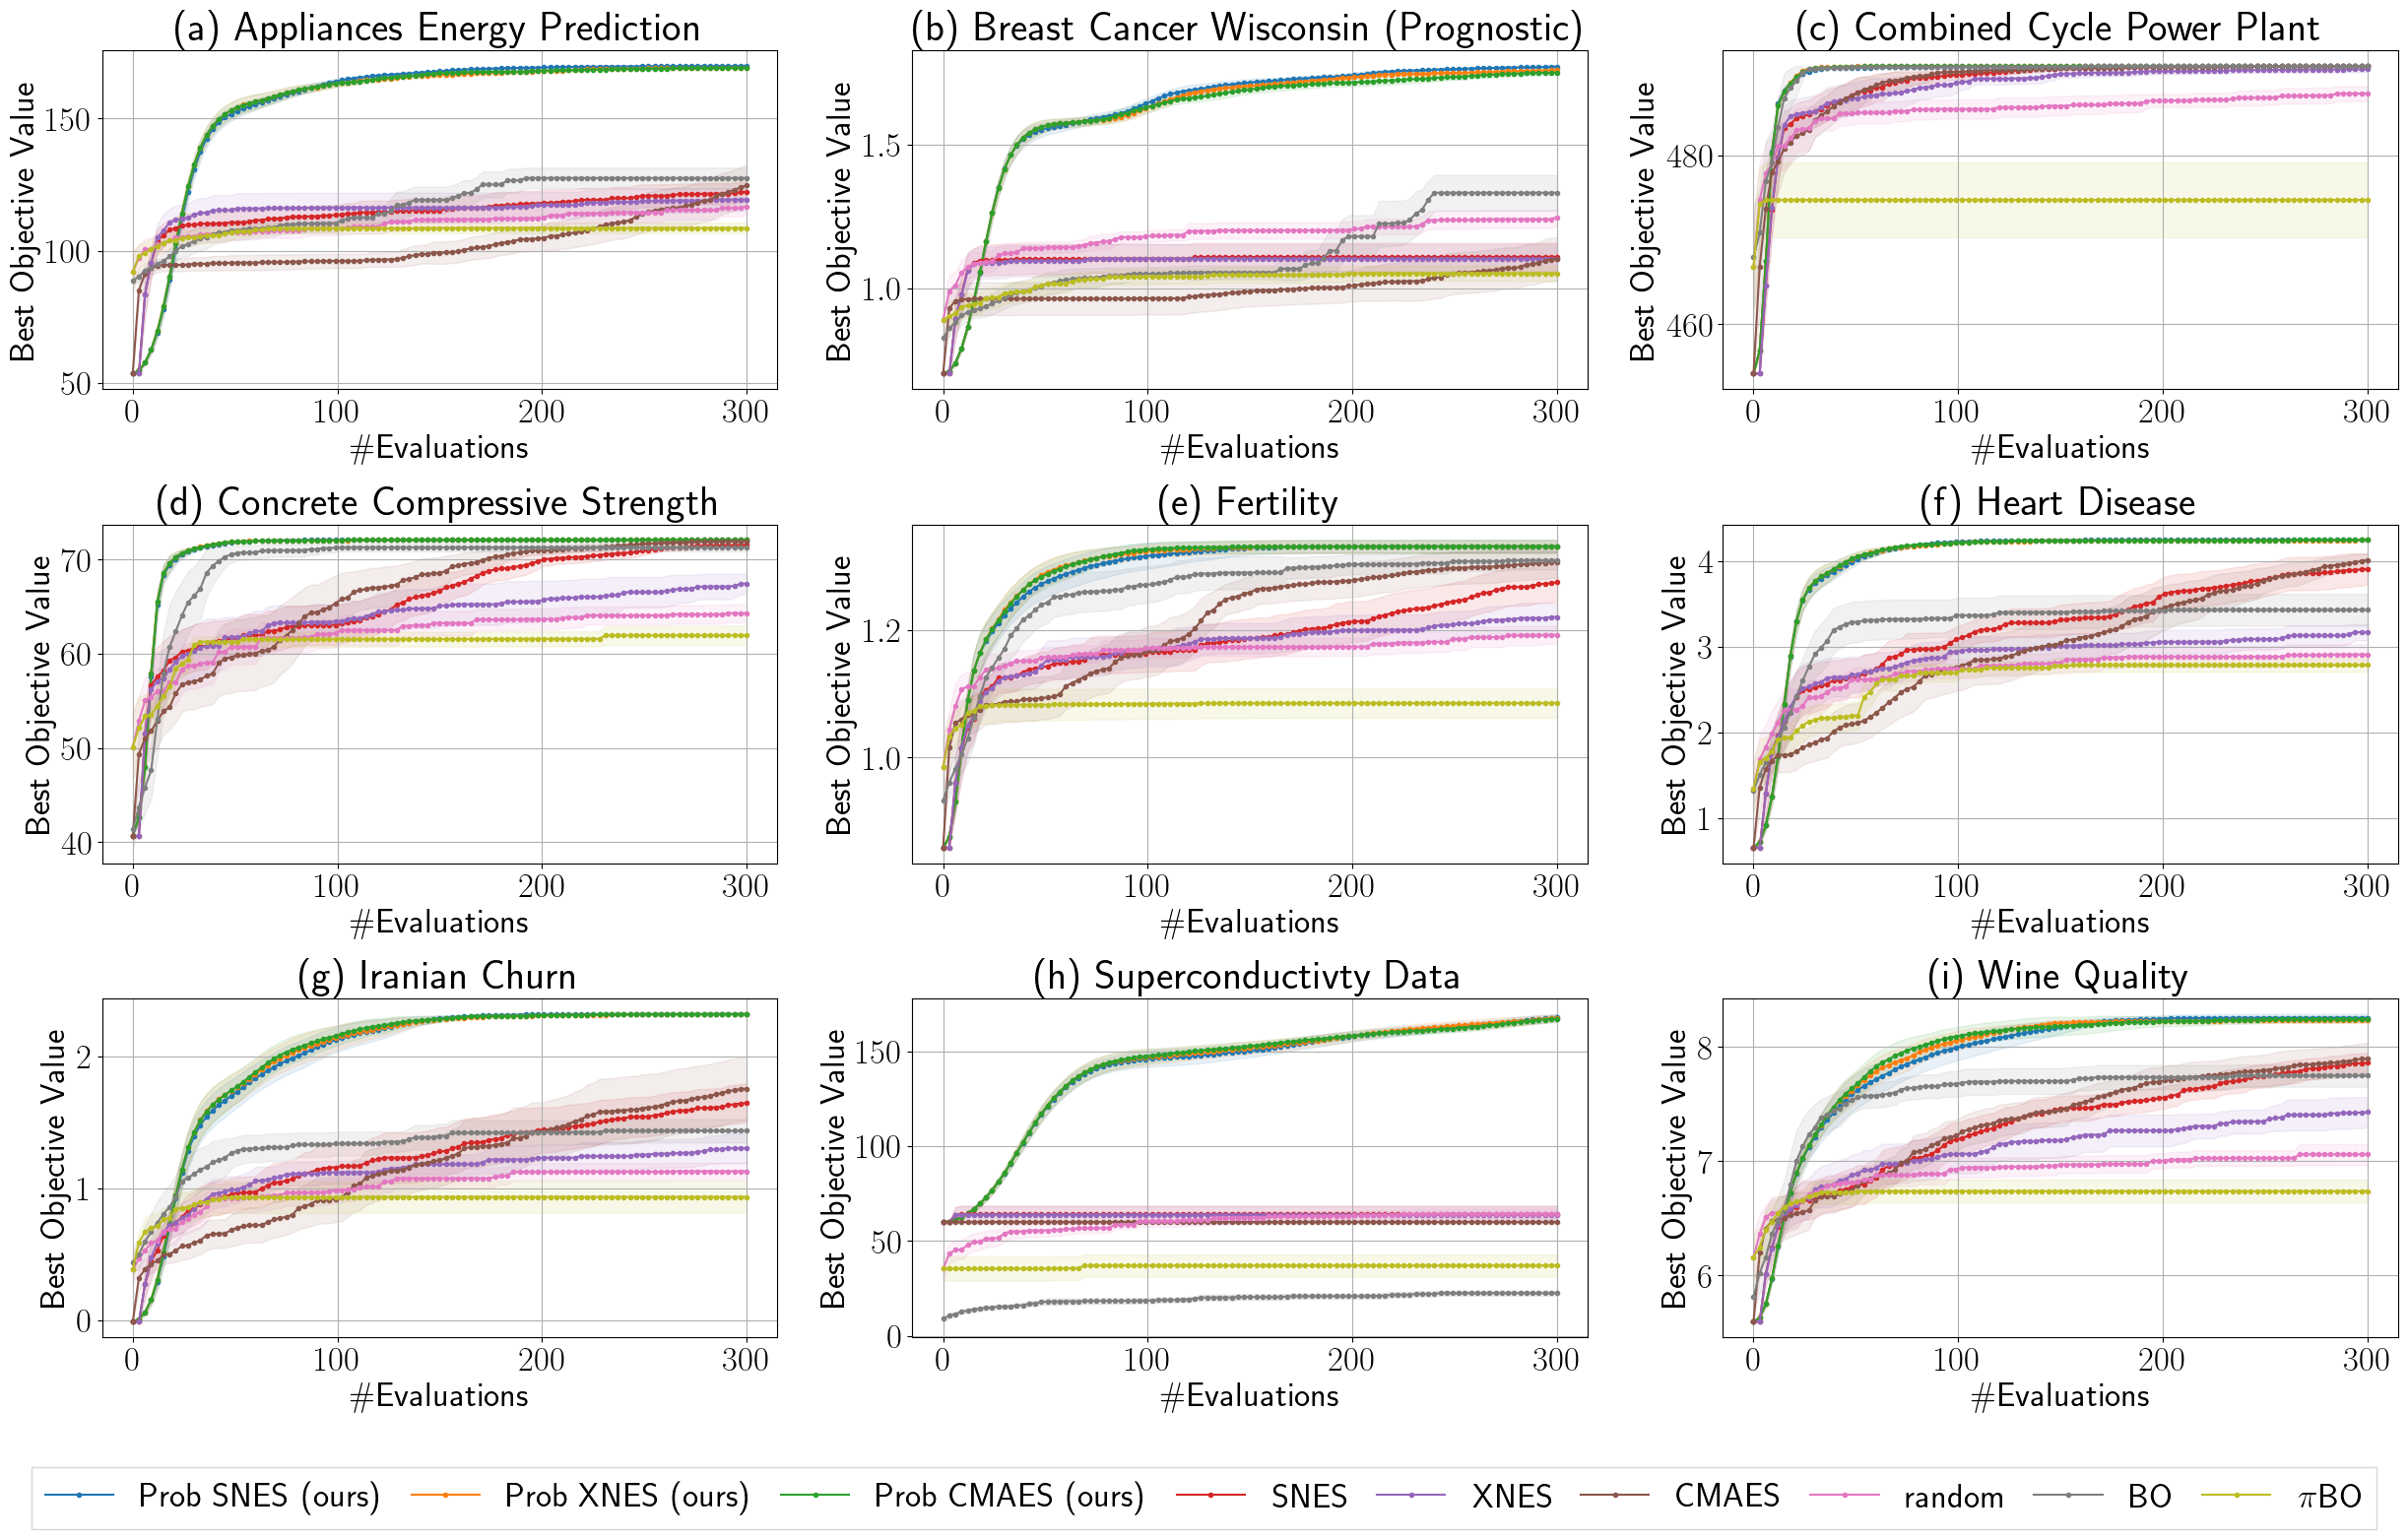

In [9]:
list_experiences = ["Appliances Energy Prediction", "Breast Cancer Wisconsin (Prognostic)", "Combined Cycle Power Plant", "Concrete Compressive Strength", "Fertility", "Heart Disease", 
                    "Iranian Churn", "Superconductivty Data", "Wine Quality"]

idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 3, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 15))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_config_functions(axs[idx_row, idx_col], list_experiences[i], config_name = "uci", regret = False)
    axs[idx_row, idx_col].title.set_text(idx_letter[i] + " " + experience)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
# change_labels = [2, 6, 7, 4, 5, 1, 3, 0]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("uci_exp.pdf", bbox_inches='tight')

# Test Functions

./logs/test_function_high_dim_rebuttal/ackley_dim-10_noise_std-0.0_initial_bounds-10.0/probES/type-SNES_policy-constant_gradient-expected_aqc_type-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean/seed-0006.pt
./logs/test_function_high_dim_rebuttal/ackley_dim-10_noise_std-0.0_initial_bounds-10.0/probES/type-SNES_policy-constant_gradient-expected_aqc_type-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean/seed-0002.pt
./logs/test_function_high_dim_rebuttal/ackley_dim-10_noise_std-0.0_initial_bounds-10.0/probES/type-SNES_policy-constant_gradient-expected_aqc_type-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean/seed-0008.pt
./logs/test_function_high_dim_rebuttal/ackley_dim-10_noise_std-0.0_initial_bounds-10.0/probES/type-SNES_policy-constant_gradient-expected_aqc_type-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-5_evaluation-mean/seed-0005.pt


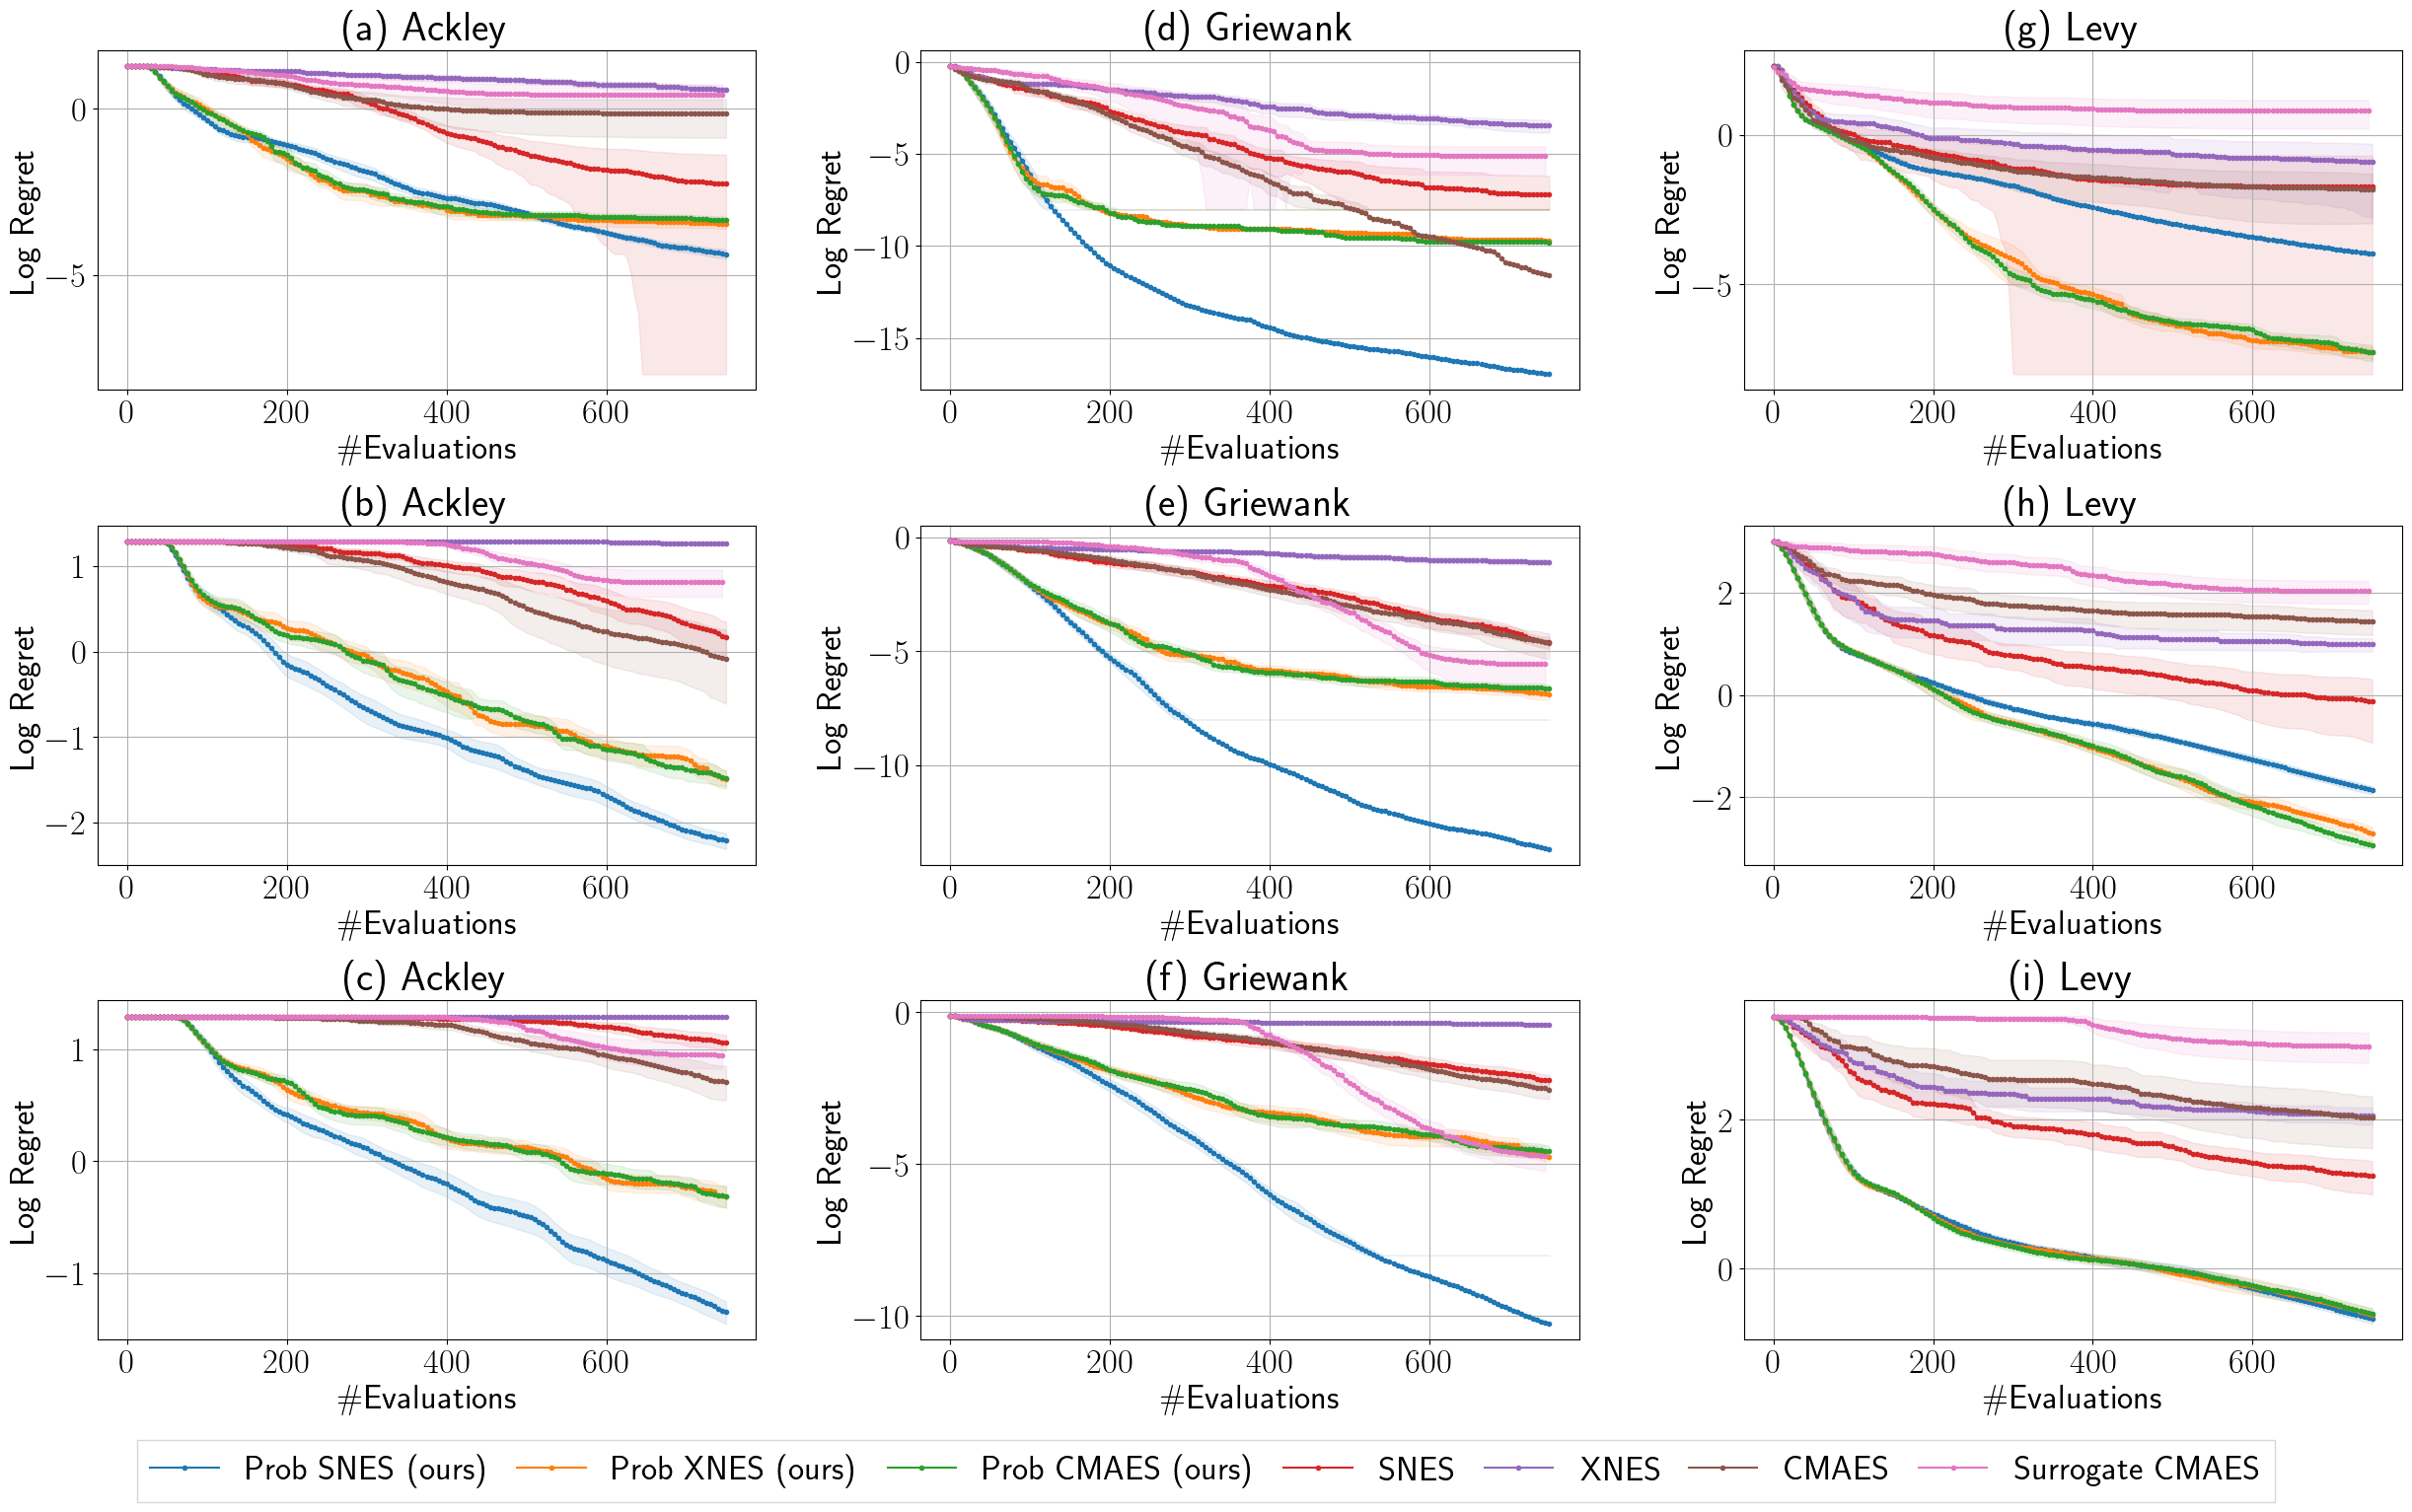

In [19]:
list_experiences = ["ackley", "Griewank", "Levy"]
list_labels = ["Ackley", "Griewank", "Levy"]
list_amin = [-8, -8, -8]
n_rows, n_cols = 3, 3
idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 15))
for i, experience in enumerate(list_experiences):
    for j, dim in enumerate([10, 20, 30]):
        plot_config_functions_dim(axs[j, i], list_experiences[i], dim, config_name = "test_function_high_dim", log_transform=True, regret = True, amin = list_amin[i])
        axs[j, i].title.set_text(idx_letter[3*i + j] + " " + list_labels[i] + f" (D = {dim})")
        axs[j, i].set_ylabel("Log Regret")

handles, labels = axs[j, i].get_legend_handles_labels()
change_labels = [0, 1, 2, 3, 4, 5, 6]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.02),fancybox=False, shadow=False, ncol=7, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.25, hspace=0.4)
plt.savefig("test_function_high_dim.pdf", bbox_inches='tight')

In [9]:
/home/pierre/Downloads/dd/test_function_high_dim_rebuttal/ackley_dim-10_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/ackley_dim-20_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/ackley_dim-30_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/Griewank_dim-10_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/Griewank_dim-20_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/Griewank_dim-30_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/Levy_dim-10_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/Levy_dim-20_noise_std-0.0_initial_bounds-10.0 /home/pierre/Downloads/dd/test_function_high_dim_rebuttal/Levy_dim-30_noise_std-0.0_initial_bounds-10.0

['SNES',
 'XNES',
 'CMAES',
 'Prob SNES (ours)',
 'Prob XNES (ours)',
 'Prob CMAES (ours)']

/tmp/ipykernel_25513/3521261278.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_25513/3521261278.py:6: Fu

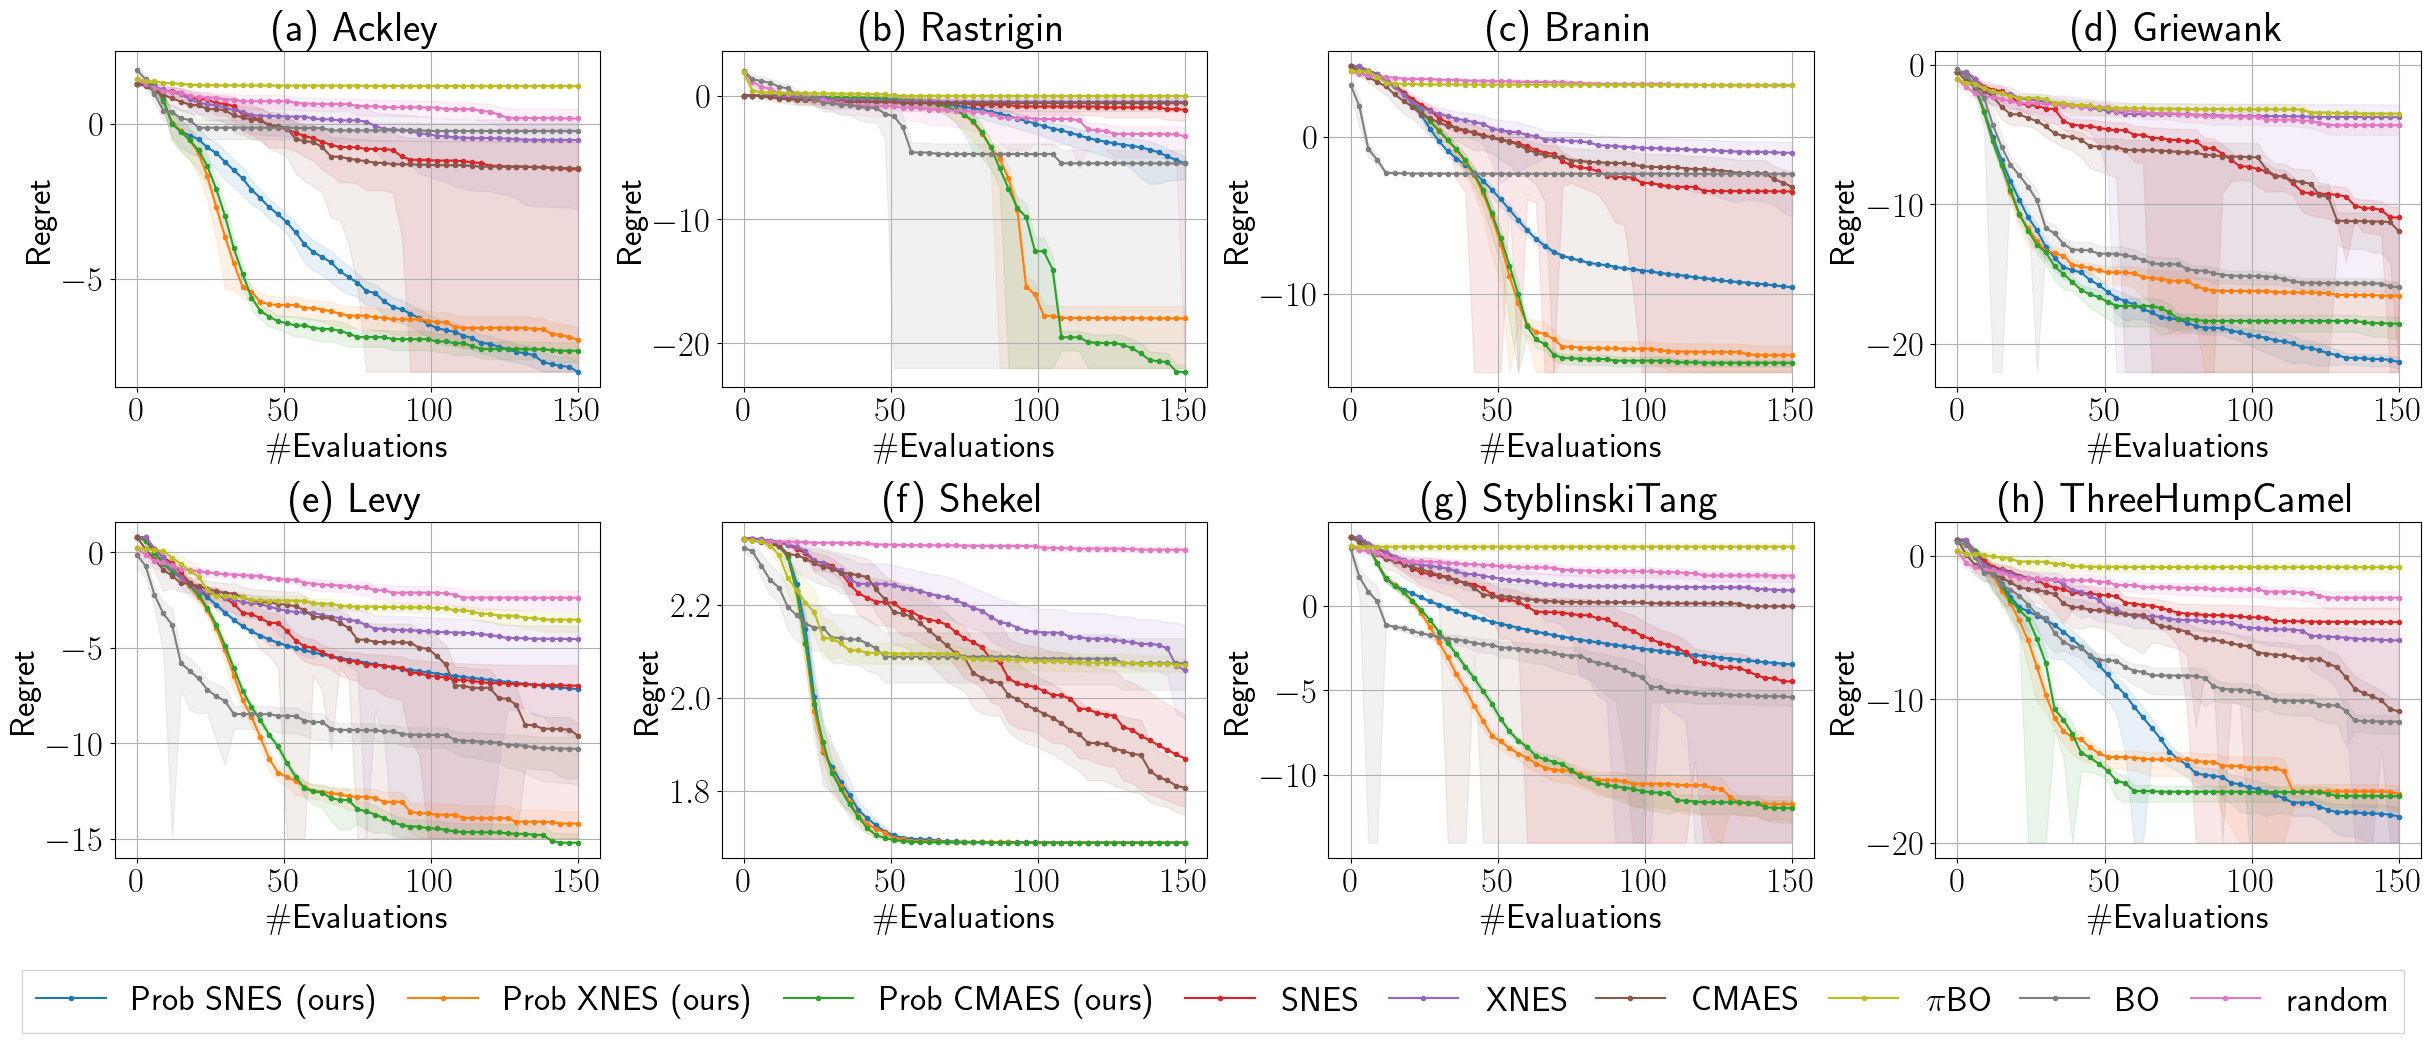

In [89]:
list_experiences = ["ackley", "rastrigin", "Branin", "Griewank", "Levy", "Shekel", "StyblinskiTang", "ThreeHumpCamel"]
list_labels = ["Ackley", "Rastrigin", "Branin", "Griewank", "Levy", "Shekel", "StyblinskiTang", "ThreeHumpCamel"]
list_amin = [-8, -22, -15, -22, -15, -5, -14, -20]
n_rows, n_cols = 2, 4
idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 10))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_config_functions(axs[idx_row, idx_col], list_experiences[i], config_name = "test_function", log_transform=True, regret = True, amin = list_amin[i])
    axs[idx_row, idx_col].title.set_text(idx_letter[i] + " " + list_labels[i])

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
change_labels = [0, 1, 2, 3, 4, 5, 8, 7, 6]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.02),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.25, hspace=0.4)
plt.savefig("test_function.pdf", bbox_inches='tight')

# Latent Space

/tmp/ipykernel_25513/3521261278.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_25513/3521261278.py:6: Fu

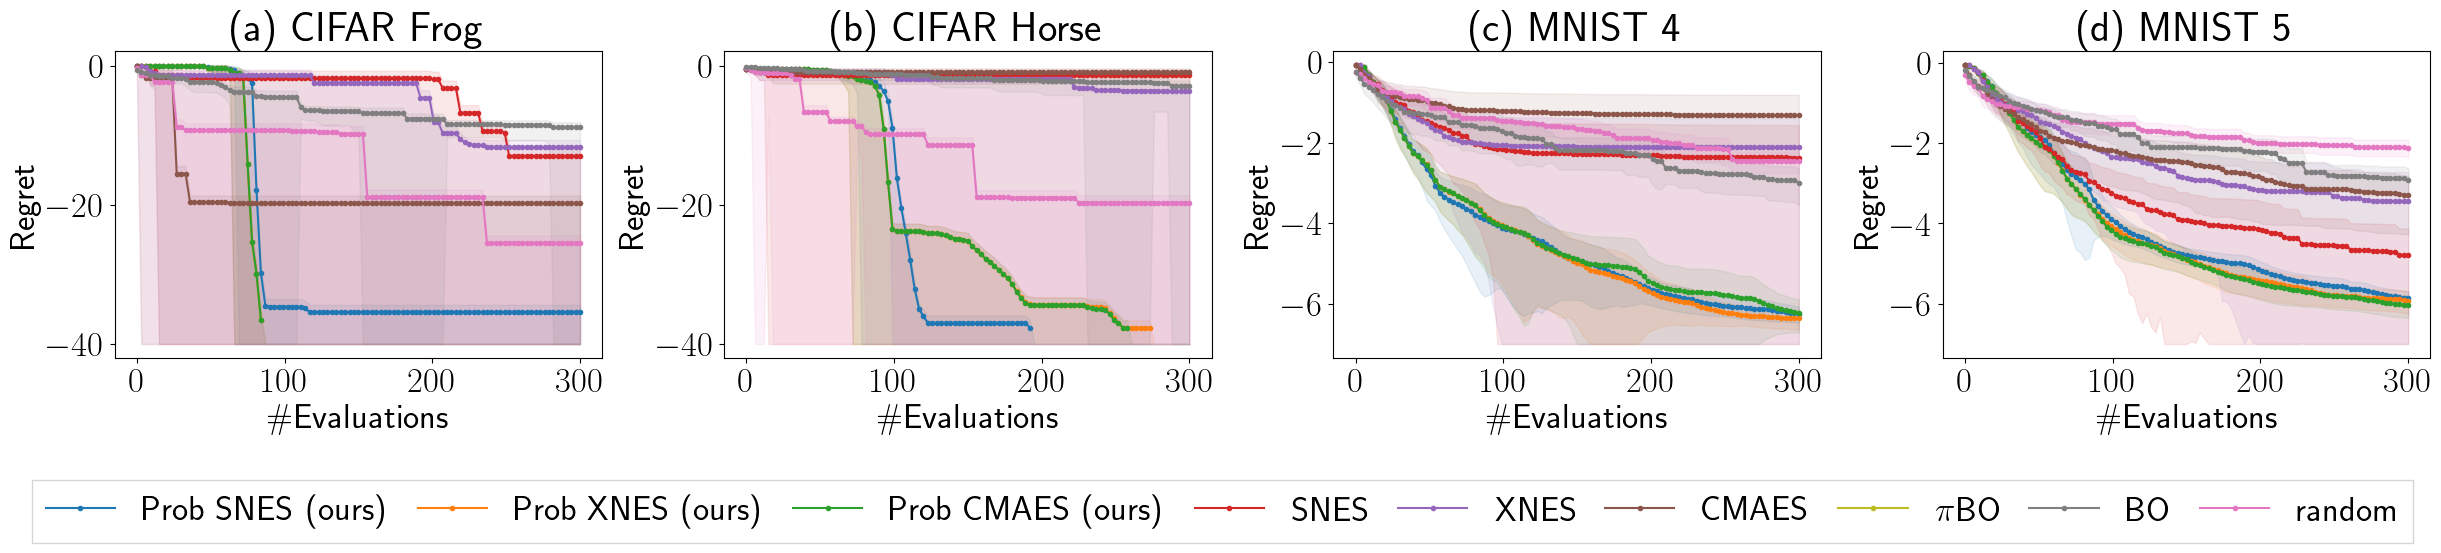

In [90]:

list_experiences = [("cifar10", 7), ("cifar10", 8), ("mnist", 4), ("mnist", 5)]
list_labels = ["CIFAR Frog", "CIFAR Horse", "MNIST 4", "MNIST 5"]
list_amin = [-40, -40, -7, -7]

idx_letter = ["(a)", "(b)", "(c)", "(d)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    plot_config_functions_labels(axs[idx_col], list_experiences[i][0], list_experiences[i][1], config_name = "latent_space", log_transform=True, regret = True, amin=list_amin[i])
    axs[idx_col].title.set_text(idx_letter[i] + " " + list_labels[i])

# handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
# change_labels = [0, 1, 2, 3, 4, 5, 8, 7, 6]
# labels = [labels[i] for i in change_labels]
# handles = [handles[i] for i in change_labels]
#fig.legend(handles, labels, loc='center')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.02),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.25, hspace=0.6)
plt.savefig("latent_space.pdf", bbox_inches='tight')

# Hyperparameter Opt

/tmp/ipykernel_6603/3313922632.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path, map_location="cpu")
/tmp/ipykernel_6603/3313922632.py:6: Futu

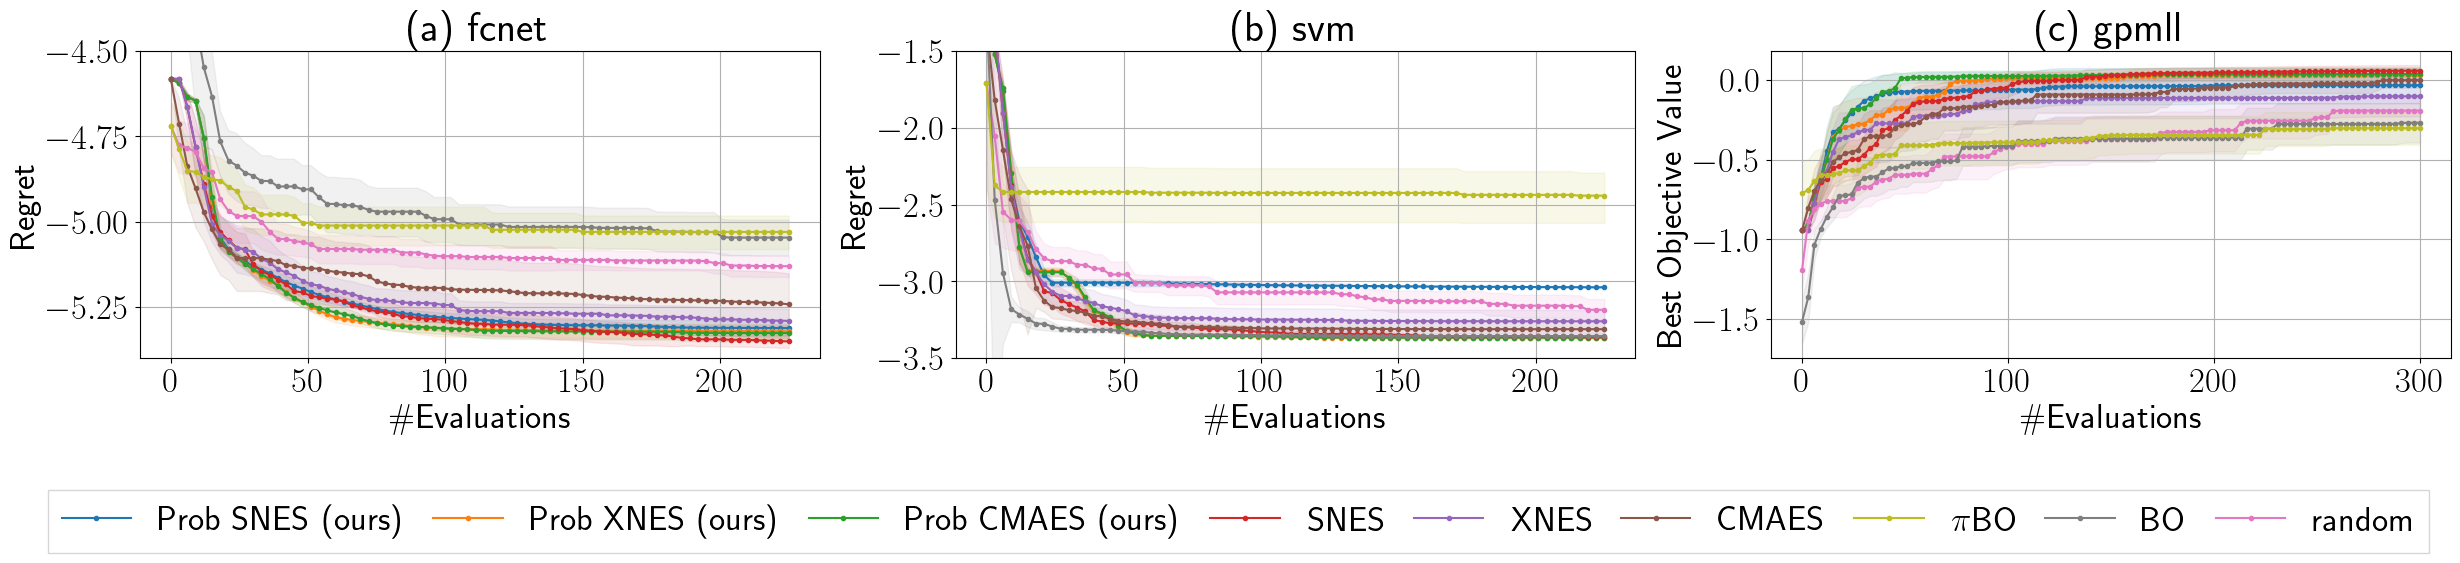

In [49]:
list_experiences = ["fcnet", "svm", "gpmll"]

idx_letter = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))

i = 0
plot_config_functions_labels(axs[i], list_experiences[i], label = 9, config_name = "hyper_probnet", log_transform=True, regret = True, amin = -20)
axs[i].title.set_text(idx_letter[i] + " " + list_experiences[i])
axs[i].set_ylim(bottom = -5.4, top = -4.5)

i = 1
plot_config_functions_labels(axs[i], list_experiences[i], label = 9, config_name = "hyper_probnet_svm", log_transform=True, regret = True, amin = -20)
axs[i].title.set_text(idx_letter[i] + " " + list_experiences[i])
axs[i].set_ylim(bottom = -3.5, top = -1.5)

i = 2
plot_config_functions_labels(axs[i], list_experiences[i], label = 0, config_name = "hyper_gpmll", log_transform=False, regret = False, amin = -20)
axs[i].title.set_text(idx_letter[i] + " " + list_experiences[i])

handles, labels = axs[2].get_legend_handles_labels()
change_labels = [0, 1, 2, 3, 4, 5, 8, 7, 6]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
# #axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
# #             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("hyper_exp.pdf", bbox_inches='tight')

# Locomotion task

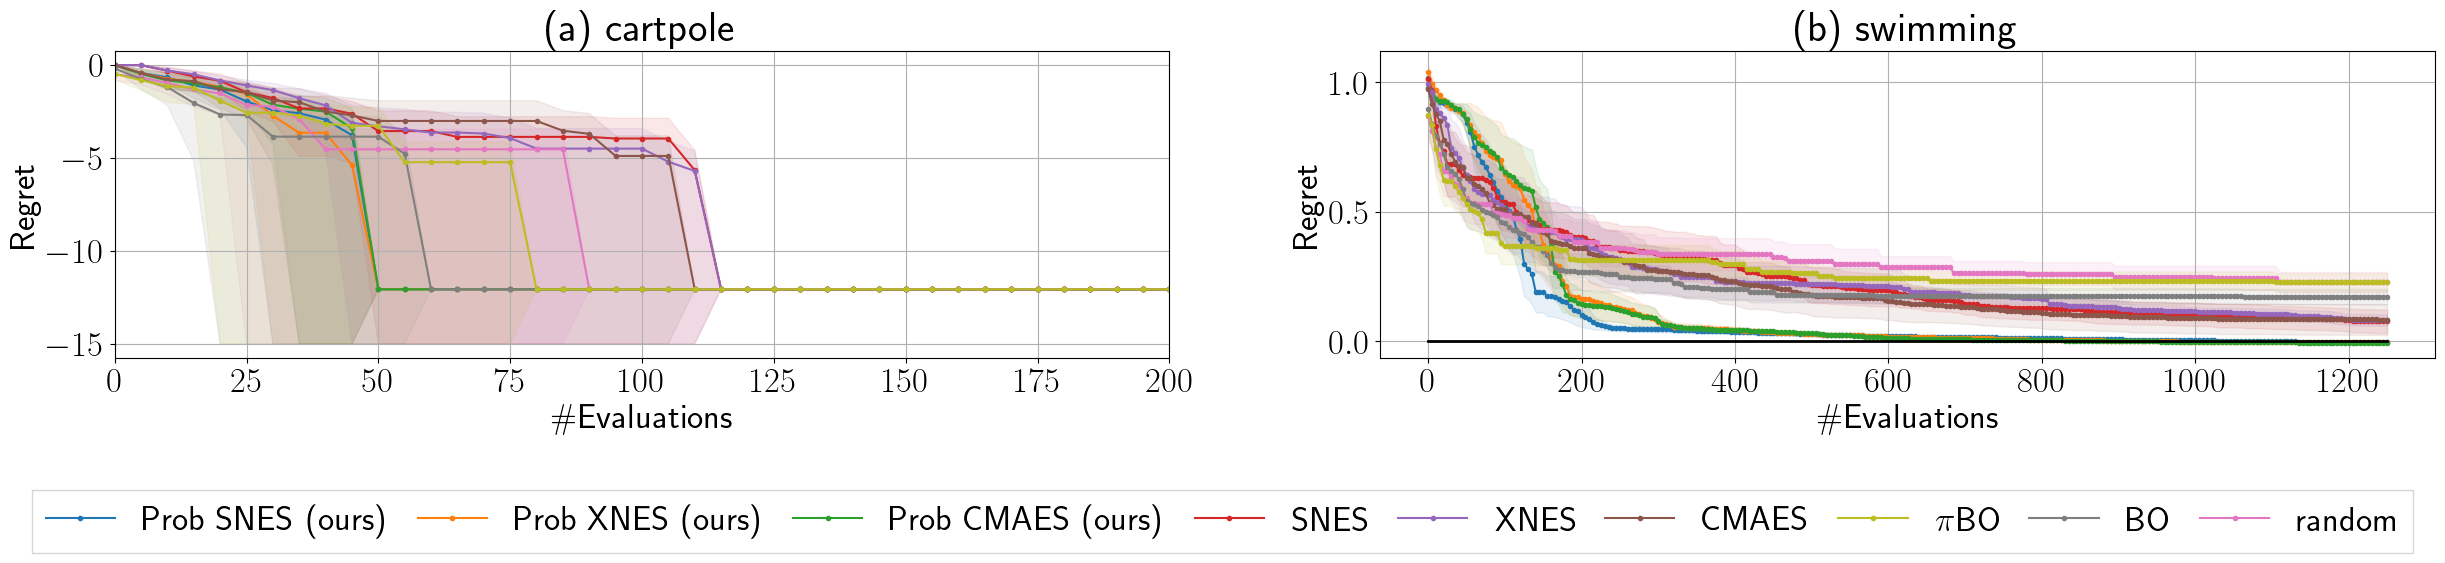

In [31]:
list_experiences = ["cartpole", "swimming"]

idx_letter = ["(a)", "(b)"]
matplotlib.rcParams.update({'font.size': 25})
n_rows, n_cols = 1, 2
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5))

i = 0
plot_config_functions(axs[i], list_experiences[i], config_name = "rl_cartpole", log_transform=True, regret = True, amin = -15)
axs[i].title.set_text(idx_letter[i] + " " + list_experiences[i])
axs[i].set_xlim(left = 0., right = 200)

i = 1
plot_config_functions(axs[i], list_experiences[i], config_name = "rl_swimmer", log_transform=False, regret = True, amin = -15)
axs[i].title.set_text(idx_letter[i] + " " + list_experiences[i])
# axs[i].set_ylim(bottom = -3.5, top = -1.5)


handles, labels = axs[1].get_legend_handles_labels()
change_labels = [0, 1, 2, 3, 4, 5, 8, 7, 6]
labels = [labels[i] for i in change_labels]
handles = [handles[i] for i in change_labels]
# axs[1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=9, columnspacing=0.8)
plt.tight_layout()
#plt.legend()
#plt.show()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.savefig("rl.pdf", bbox_inches='tight')

In [8]:
d = torch.load("/home/pierre/git/ProbNES/semisupervised/logs/test_function_time/ackley_noise_std-0.0_initial_bounds-3.0/ES/type-CMAES_mean_prior--1.0_std_prior-1.0_batch_size-3_evaluation-mean/seed-0000.pt", map_location=torch.device('cpu'))

In [9]:
d

{'label': 'ES',
 'X': tensor([[-6.7079e-01, -7.4927e-01],
         [-9.4475e-02, -1.4100e+00],
         [-1.9453e+00,  1.1075e+00],
         [ 4.6688e-01, -1.1744e+00],
         [-8.8418e-01, -3.2516e-02],
         [-1.2182e+00, -7.6979e-01],
         [-5.0282e-01,  6.2108e-01],
         [-1.1204e+00, -1.9627e-01],
         [-5.1032e-01,  8.8630e-01],
         [-1.3371e+00, -6.0481e-01],
         [-2.1315e+00, -7.3275e-01],
         [-2.0007e+00, -1.2061e-01],
         [-6.7206e-01, -4.5275e-01],
         [-2.7424e+00,  4.3676e-01],
         [-2.0287e+00, -1.2149e+00],
         [-5.8216e-01, -1.3727e+00],
         [-1.0578e+00, -1.2175e+00],
         [-1.0025e+00,  7.1216e-02],
         [-6.0448e-01, -4.8119e-01],
         [-1.4426e+00,  1.2025e+00],
         [-1.3746e+00,  9.9630e-02],
         [-1.0013e+00, -4.8124e-01],
         [-2.5900e-01, -3.9169e-01],
         [ 2.9888e-01, -4.2897e-01],
         [ 2.4858e-01, -5.4334e-01],
         [-4.2580e-01,  1.2349e-01],
         [-5.3995

In [10]:
d["wall_time"]

tensor([0.0000, 0.0024, 0.0047, 0.0070, 0.0092, 0.0115, 0.0138, 0.0161, 0.0184,
        0.0207, 0.0229, 0.0252, 0.0275, 0.0298, 0.0321, 0.0343, 0.0366, 0.0389,
        0.0412, 0.0435, 0.0458, 0.0480, 0.0503, 0.0526, 0.0548, 0.0571, 0.0594,
        0.0617, 0.0639, 0.0662, 0.0685, 0.0707, 0.0730, 0.0753, 0.0775, 0.0798,
        0.0820, 0.0843, 0.0866, 0.0889, 0.0912, 0.0935, 0.0957, 0.0980, 0.1003,
        0.1027, 0.1049, 0.1072, 0.1095, 0.1118, 0.1141], dtype=torch.float64)

ES

In [80]:
obj = "Branin" # ["rastrigin", "ThreeHumpCamel", "StyblinskiTang", "Shekel", "Levy", "Griewank", "Branin", "ackley"]
alg = "ES" # ProbES
alg_name = "XNES"
dir = f"/home/pierre/git/ProbNES/semisupervised/logs/test_function_time/{obj}_noise_std-0.0_initial_bounds-3.0/{alg}/type-{alg_name}_mean_prior--1.0_std_prior-1.0_batch_size-3_evaluation-mean"

data_path_seeds = [f for f in os.listdir(dir) if ".pt" in f]
data_over_seeds = []
for _, df in enumerate(data_path_seeds):
    data_path = os.path.join(dir, df)
    data = torch.load(data_path, map_location="cpu")
    data_over_seeds.append(data["wall_time"])
d = torch.stack(data_over_seeds, dim = 0)
d.mean(dim = 0)[20]

tensor(0.0614, dtype=torch.float64)

probes

In [102]:
obj = "Branin" # ["rastrigin", "ThreeHumpCamel", "StyblinskiTang", "Shekel", "Levy", "Griewank", "Branin", "ackley"]
alg = "ES" # ProbES
alg_name = "XNES"
dir = f"/home/pierre/git/ProbNES/semisupervised/logs/test_function_time/{obj}_noise_std-0.0_initial_bounds-3.0/probES/type-{alg_name}_policy-constant_gradient-expected_aqc_type-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3_evaluation-mean"
data_path_seeds = [f for f in os.listdir(dir) if ".pt" in f]
data_over_seeds = []
for _, df in enumerate(data_path_seeds):
    data_path = os.path.join(dir, df)
    data = torch.load(data_path, map_location="cpu")
    data_over_seeds.append(data["wall_time"])
d = torch.stack(data_over_seeds, dim = 0)
d.mean(dim = 0)[20]

tensor(7.9972, dtype=torch.float64)

qei

In [110]:
obj = "Branin" # ["rastrigin", "ThreeHumpCamel", "StyblinskiTang", "Shekel", "Levy", "Griewank", "Branin", "ackley"]
dir = f"/home/pierre/git/ProbNES/semisupervised/logs/test_function_time/{obj}_noise_std-0.0_initial_bounds-3.0/qEI/batch_size-3"
data_path_seeds = [f for f in os.listdir(dir) if ".pt" in f]
data_over_seeds = []
for _, df in enumerate(data_path_seeds):
    data_path = os.path.join(dir, df)
    data = torch.load(data_path, map_location="cpu")
    data_over_seeds.append(data["wall_time"])
d = torch.stack(data_over_seeds, dim = 0)
d.mean(dim = 0)[20]

tensor(14.9026, dtype=torch.float64)

piqei

In [119]:
obj = "Branin" # ["rastrigin", "ThreeHumpCamel", "StyblinskiTang", "Shekel", "Levy", "Griewank", "Branin", "ackley"]
dir = f"/home/pierre/git/ProbNES/semisupervised/logs/test_function_time/{obj}_noise_std-0.0_initial_bounds-3.0/piqEI/beta-1.0_mean_prior--1.0_std_prior-1.0_batch_size-3"
data_path_seeds = [f for f in os.listdir(dir) if ".pt" in f]
data_over_seeds = []
for _, df in enumerate(data_path_seeds):
    data_path = os.path.join(dir, df)
    data = torch.load(data_path, map_location="cpu")
    data_over_seeds.append(data["wall_time"])
d = torch.stack(data_over_seeds, dim = 0)
d.mean(dim = 0)[20]

tensor(34.2268, dtype=torch.float64)

Random

In [47]:
obj = "Branin" # ["ackley", "rastrigin", "ThreeHumpCamel", "StyblinskiTang", "Shekel", "Levy", "Griewank", "Branin"]
dir = f"/home/pierre/git/ProbNES/semisupervised/logs/test_function_time/{obj}_noise_std-0.0_initial_bounds-3.0/random/mean_prior--1.0_std_prior-1.0_batch_size-3"
data_path_seeds = [f for f in os.listdir(dir) if ".pt" in f]
data_over_seeds = []
for _, df in enumerate(data_path_seeds):
    data_path = os.path.join(dir, df)
    data = torch.load(data_path, map_location="cpu")
    data_over_seeds.append(data["wall_time"])
d = torch.stack(data_over_seeds, dim = 0)
d.mean(dim = 0)[20]

tensor(0.0036, dtype=torch.float64)